In [1]:
import time
from contextlib import contextmanager

@contextmanager
def timer():
    start = time.time()
    yield
    print('Elapsed: {:.2f}ms'.format((time.time() - start)*1000))

# TORCH

In [2]:
import torch
print(torch.__version__)

1.13.1


/home/dojan/anaconda3/envs/selfpose3d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
gpus = [0]

In [4]:
if torch.cuda.is_available():
    torch.cuda.set_device(gpus[0])
    device = torch.device("cuda")
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = False

print(device)

cuda


In [5]:
import pickle

with open('view.pkl', 'rb') as f:
    view = pickle.load(f)

In [6]:
import copy

original = copy.deepcopy(view)

In [7]:
ckpt_path = 'SelfPose3d/models/POC_posenet.pth.tar'

In [8]:
import _init_paths
from SelfPose3d.lib.core.config import config, update_config

update_config(r"/home/dojan/FOCUS-1/modules/SelfPose3d/config/cam4_posenet.yaml")

In [9]:
from SelfPose3d.lib.models.multi_person_posenet_ssv import get_multi_person_pose_net

with torch.no_grad():
    model = get_multi_person_pose_net(cfg=config, is_train=True)

    model = model.to(device)
    model.load_state_dict(torch.load(r"/home/dojan/FOCUS-1/modules/SelfPose3d/models/POC_posenet.pth.tar"), strict=False)

model.eval()

MultiPersonPoseNetSSV(
  (backbone): PoseResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seq

In [10]:
from SelfPose3d.lib.models.pose_resnet import get_pose_net

backbone = get_pose_net(cfg=config, is_train=True)

In [11]:
backbone = model.backbone.eval()

In [12]:
view = copy.deepcopy(original)
with timer():
    result = backbone(view)

Elapsed: 550.13ms


In [13]:
view = copy.deepcopy(original)
with timer():
    result = backbone(view)

Elapsed: 7.06ms


In [14]:
with open('heatmaps.pkl', 'rb') as f:
    heatmaps = pickle.load(f)

In [15]:
similarity = torch.nn.functional.cosine_similarity(result, heatmaps, dim=1)

In [16]:
similarity.mean()

tensor(1., device='cuda:0', grad_fn=<MeanBackward0>)

# ONNX

In [17]:
torch.onnx.export(
    model=backbone,
    args=(view,),   # 1, 3, 512, 960
    f='backbone.onnx',
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch', 2: 'height', 3: 'width'},
        'output': {0: 'batch'}
    },
    opset_version=11,
)

/home/dojan/FOCUS-1/tools/../modules/SelfPose3d/lib/models/pose_resnet.py:205: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn:


In [18]:
import onnx

In [19]:
backbone_onnx = onnx.load('backbone.onnx')

In [20]:
onnx.checker.check_model(backbone_onnx, True)

In [21]:
print(onnx.helper.printable_graph(backbone_onnx.graph))

graph torch_jit (
  %input[FLOAT, batchx3xheightxwidth]
) initializers (
  %deconv_layers.0.weight[FLOAT, 2048x256x4x4]
  %deconv_layers.1.weight[FLOAT, 256]
  %deconv_layers.1.bias[FLOAT, 256]
  %deconv_layers.1.running_mean[FLOAT, 256]
  %deconv_layers.1.running_var[FLOAT, 256]
  %deconv_layers.3.weight[FLOAT, 256x256x4x4]
  %deconv_layers.4.weight[FLOAT, 256]
  %deconv_layers.4.bias[FLOAT, 256]
  %deconv_layers.4.running_mean[FLOAT, 256]
  %deconv_layers.4.running_var[FLOAT, 256]
  %deconv_layers.6.weight[FLOAT, 256x256x4x4]
  %deconv_layers.7.weight[FLOAT, 256]
  %deconv_layers.7.bias[FLOAT, 256]
  %deconv_layers.7.running_mean[FLOAT, 256]
  %deconv_layers.7.running_var[FLOAT, 256]
  %final_layer.weight[FLOAT, 15x256x1x1]
  %final_layer.bias[FLOAT, 15]
  %onnx::Conv_523[FLOAT, 64x3x7x7]
  %onnx::Conv_524[FLOAT, 64]
  %onnx::Conv_526[FLOAT, 64x64x1x1]
  %onnx::Conv_527[FLOAT, 64]
  %onnx::Conv_529[FLOAT, 64x64x3x3]
  %onnx::Conv_530[FLOAT, 64]
  %onnx::Conv_532[FLOAT, 256x64x1x1]
  

In [22]:
import onnxruntime as ort
ort_session = ort.InferenceSession('backbone.onnx')

In [23]:
view = copy.deepcopy(original)
view = view.detach().cpu().numpy()
with timer():
    outptus = ort_session.run(None, {'input': view})

Elapsed: 170.04ms


In [24]:
view = copy.deepcopy(original)
view = view.detach().cpu().numpy()
with timer():
    outptus = ort_session.run(None, {'input': view})

Elapsed: 156.16ms


In [25]:
similarity3 = torch.nn.functional.cosine_similarity(torch.tensor(outptus[0], device=device), heatmaps, dim=1)

In [26]:
similarity3.mean()

tensor(0.9999, device='cuda:0')

# TENSORRT

In [27]:
import tensorrt as trt

In [28]:
class MyLogger(trt.ILogger):
    def __init__(self, level=trt.Logger.INFO):
        trt.ILogger.__init__(self)
        self.level = level.value
    
    def log(self, severity, msg):
        if severity.value <= self.level:
            print(f'[{severity.name:^14}] {msg}')

TRT_LOGGER = MyLogger(trt.Logger.INFO)

In [29]:
def check_version(library_name, min, max):
    try:
        import sys
        if sys.version_info >= (3, 8):
            import importlib.metadata as metadata
            version = metadata.version(library_name)
        else:
            import pkg_resources as metadata
            version = metadta.get_distribution(library_name).version
        
        TRT_LOGGER.log(trt.Logger.INFO, f'{library_name} version: {version}')
        from packaging import version as pkg_version
        if min <= pkg_version.parse(version) <= max:
            TRT_LOGGER.log(trt.Logger.INFO, f'{library_name} version is compatible')
        else:
            TRT_LOGGER.log(trt.Logger.ERROR, f'{library_name} version is not compatible')
    except (metadata.PackageNotFoundError, metadata.DistributionNotFound):
        TRT_LOGGER.log(trt.Logger.ERROR, f'{library_name} is not installed')

In [30]:
def build_engine(onnx_file_path, engine_file_path, half=False, int8=False, dynamic_shape=True, opt_shape=(1, 3, 512, 960), io_mode=True):
    try:
        import tensorrt as trt
    except ImportError:
        import platform
        if platform.system() == 'Linux':
            check_version('tensorrt', '7.0.0', '10.1.0')
    

    prefix = 'ONNX'
    builder = trt.Builder(TRT_LOGGER)
    network = builder.create_network(1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
    parser = trt.OnnxParser(network, TRT_LOGGER)
    with open(onnx_file_path, 'rb') as model:
        if not parser.parse(model.read()):
            print('Failed to parse the ONNX file')
            for error in range(parser.num_errors):
                print(parser.get_error(error))
            return None
    TRT_LOGGER.log(trt.Logger.INFO, 'ONNX file has been parsed successfully')


    prefix = 'TensorRT'
    TRT_LOGGER.log(trt.Logger.INFO, f'Starting building engine with TensorRT version: {trt.__version__}...')
    is_trt10 = int(trt.__version__.split('.')[0]) >= 10
    
    
    config = builder.create_builder_config()
    if is_trt10:
        config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 1 << 30)
        # config.set_flag(trt.BuilderFlag.DEBUG)
    else:
        builder.max_workspace_size = 1 << 30
        # builder.debug_sync = True
    
    # Network inputs
    inputs = [network.get_input(i) for i in range(network.num_inputs)]
    outputs = [network.get_output(i) for i in range(network.num_outputs)]
    for inp in inputs:
        TRT_LOGGER.log(trt.Logger.INFO, f'input "{inp.name}" with shape: {inp.shape} {inp.dtype}')
    for out in outputs:
        TRT_LOGGER.log(trt.Logger.INFO, f'output "{out.name}" with shape: {out.shape} {out.dtype}')
    
    if dynamic_shape:
        TRT_LOGGER.log(trt.Logger.INFO, 'Dynamic shape is enabled')
        profile = builder.create_optimization_profile()
        for inp in inputs:
            profile.set_shape('input', min=(1, 3, 224, 224), opt=opt_shape, max=(1, 3, 1080, 1920))
        config.add_optimization_profile(profile)
    
    available_half = builder.platform_has_fast_fp16 and half
    available_int8 = builder.platform_has_fast_int8 and int8
    TRT_LOGGER.log(trt.Logger.INFO, f'FP16 capability: {available_half}, INT8 capability: {available_int8}')
    
    # from YOLO
    if available_int8:
        TRT_LOGGER.log(trt.Logger.VERBOSE, 'TODO INT8')
        # config.set_flag(trt.BuilderFlag.INT8)
        # config.set_calibration_profile(profile)
        # config.profiling_verbosity = trt.ProfilingVerbosity.DETAILED
        
        # class EngineCalibraotr(trt.IInt8Calibrator):
        #     def __init__(self, dataset, batch: int, cache: str = ""):
        #         trt.IInt8Calibrator.__init__(self)
        #         self.dataset = dataset
        #         self.data_iter = iter(dataset)
        #         self.algo = trt.CalibrationAlgoType.ENTROPY_CALIBRATION_2
        #         self.batch = batch
        #         self.cache = Path(cache)
        #     def get_algorithm(self) -> trt.CalibrationAlgoType:
        #         return self.algo
        #     def get_batch_size(self) -> int:
        #         return self.batch or 1
        #     def get_batch(self, names) -> list:
        #         try:
        #             im0s = next(self.data_iter)
        #             batch = next(self.data_iter)
        #         except StopIteration:
        #             self.data_iter = iter(self.dataset)
        #             batch = next(self.data_iter)
        #         return [batch]
        # TRT_LOGGER.log(trt.Logger.VERBOSE, 'INT8 mode is enabled')
        # https://github.com/ultralytics/ultralytics/blob/main/ultralytics/engine/exporter.py#L679
    elif available_half:
        config.set_flag(trt.BuilderFlag.FP16)
        TRT_LOGGER.log(trt.Logger.VERBOSE, 'FP16 mode is enabled')
    else:
        TRT_LOGGER.log(trt.Logger.VERBOSE, 'FP32 mode is enabled')

    build = builder.build_serialized_network if is_trt10 else builder.build_engine
    with build(network, config) as engine, open(engine_file_path, 'wb') as f:
        # Metadata
        # meta = json.dumps(self.metadata)
        # t.write(len(meta).to_bytes(4, byteorder="little", signed=True))
        # t.write(meta.encode())
        # Model
        f.write(engine if is_trt10 else engine.serialize())
    
        if engine is None:
            TRT_LOGGER.log(trt.Logger.ERROR, 'Failed to build the engine')
            return None
    
        TRT_LOGGER.log(trt.Logger.INFO, 'Engine has been built successfully')
        return engine

In [31]:
serialized_engine = build_engine('backbone.onnx', 'backbone.engine', half=True)

[     INFO     ] [MemUsageChange] Init CUDA: CPU +2, GPU +0, now: CPU 3530, GPU 3698 (MiB)
[     INFO     ] [MemUsageChange] Init builder kernel library: CPU +2175, GPU +410, now: CPU 5860, GPU 4108 (MiB)
[     INFO     ] ONNX file has been parsed successfully
[     INFO     ] Starting building engine with TensorRT version: 10.3.0...
[     INFO     ] input "input" with shape: (-1, 3, -1, -1) DataType.FLOAT
[     INFO     ] output "output" with shape: (-1, 15, -1, -1) DataType.FLOAT
[     INFO     ] Dynamic shape is enabled
[     INFO     ] FP16 capability: True, INT8 capability: False
[     INFO     ] Local timing cache in use. Profiling results in this builder pass will not be stored.
[     INFO     ] Detected 1 inputs and 1 output network tensors.
[     INFO     ] Total Host Persistent Memory: 344832
[     INFO     ] Total Device Persistent Memory: 689152
[     INFO     ] Total Scratch Memory: 52742656
[     INFO     ] [BlockAssignment] Started assigning block shifts. This will take 

In [32]:
def load_engine(engine_path, logger=TRT_LOGGER):
    with open(engine_path, 'rb') as f, trt.Runtime(logger) as runtime:
        return runtime.deserialize_cuda_engine(f.read())

In [33]:
engine = load_engine('backbone.engine')

[     INFO     ] Loaded engine size: 67 MiB


In [34]:
from SelfPose3d.lib.models.engine_model import EngineModel

engine_model = EngineModel('backbone.engine')

[     INFO     ] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[     INFO     ] Loaded engine size: 67 MiB
[     INFO     ] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +144, now: CPU 0, GPU 274 (MiB)


In [35]:
view = copy.deepcopy(original)
with timer():
    result2 = engine_model(view)

Elapsed: 1.16ms


In [36]:
view = copy.deepcopy(original)
with timer():
    result2 = engine_model(view)

Elapsed: 1.36ms


In [37]:
similarity2 = torch.nn.functional.cosine_similarity(result2, heatmaps, dim=1)

In [38]:
similarity2.mean()

tensor(0.9980, device='cuda:0')

# VISUALIZAITON

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


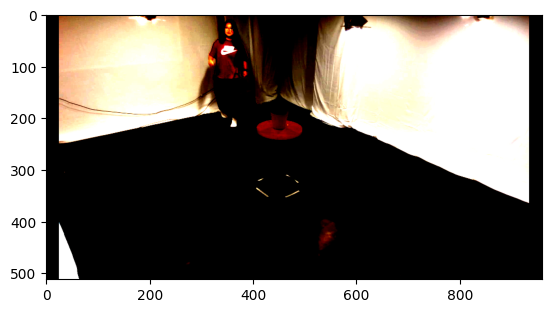

In [39]:
import matplotlib.pyplot as plt

img = original[0].detach().permute(1, 2, 0).cpu().numpy()

plt.imshow(img[..., ::-1])

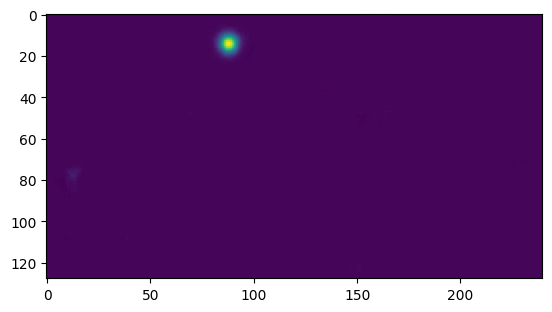

In [40]:
plt.imshow(heatmaps[0][0].cpu().numpy())

torch일 때

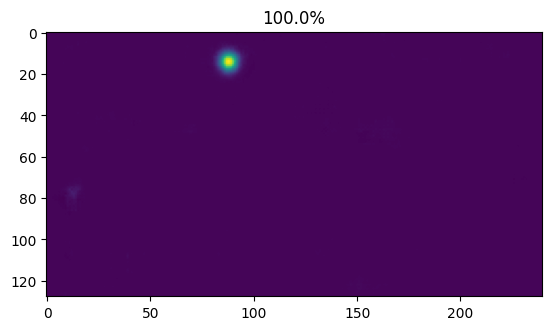

In [41]:
plt.title(f'{similarity.mean().item() * 100}%')

plt.imshow(result[0][0].detach().cpu().numpy())

onnx일 때

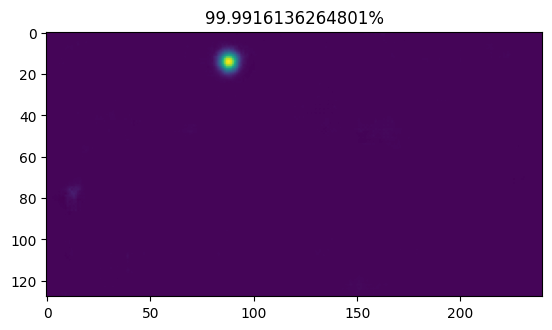

In [42]:
plt.title(f'{similarity3.mean().item() * 100}%')

plt.imshow(outptus[0][0][0])

engine일 때

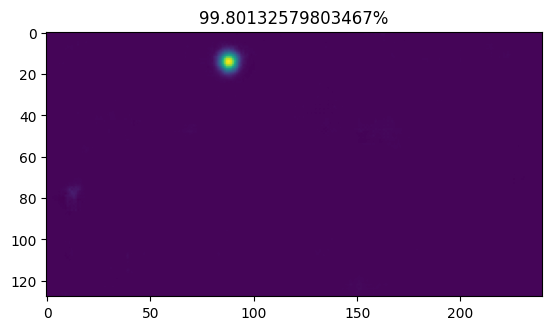

In [43]:
plt.title(f'{similarity2.mean().item() * 100}%')

plt.imshow(result2[0][0].detach().cpu().numpy())